# Cardio Predictor  
### IE0005 Group 3 Mini_Project  
* Lim Wanne, Huang Ziheng, Fang Mingzhi, Xu Zhanghao, Zheng Zelin.  
- updated 2025.04.14  

In [8]:
# Basic Libraries.
import seaborn as sb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
sb.set_theme()

# Interface Libraries  
import streamlit as st

# Analysing Libraries
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go

In [9]:
# Raw data in dataset is seperated by ';', therefore we arrange catergories by indicating that.
data = pd.read_csv('cardio_train.csv', sep=';')

# data: original csv in dataframe from.
data.head(5)  

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


## Basic Data Visualization  

1. Delete the impossible value & standardlize the dataset.  

In [10]:
# Age is provided in days, hence i would like to convert to agin years
data['age_years'] = data['age']// 365

# Remove unrealistic height and weight values
data = data[(data['height'].between(100, 220)) & (data['weight'].between(30, 200))]

# Remove unrealistic blood pressure values
data = data[(data['ap_hi'].between(90, 180)) & (data['ap_lo'].between(60, 120))]

# new category, blood pressure ratio
data['bp_ratio'] = data['ap_hi'] / data['ap_lo']

# calculation of new category, bmi, with the formula below
data['bmi'] = data['weight'] / ((data['height'] / 100) ** 2)

# Remove unrealistic BMI values
data = data[data['bmi'].between(15, 50)]

# Sort out the data according to different categories
sorted_data = data.sort_values(by=['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'])

# Display the first few rows of the sorted data
sorted_data.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bp_ratio,bmi
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50,1.375000,21.967120
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55,1.555556,34.927679
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,51,1.857143,23.507805
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48,1.500000,28.710479
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,47,1.666667,23.011177


1.1 Univariate Visualization  

* numerical data

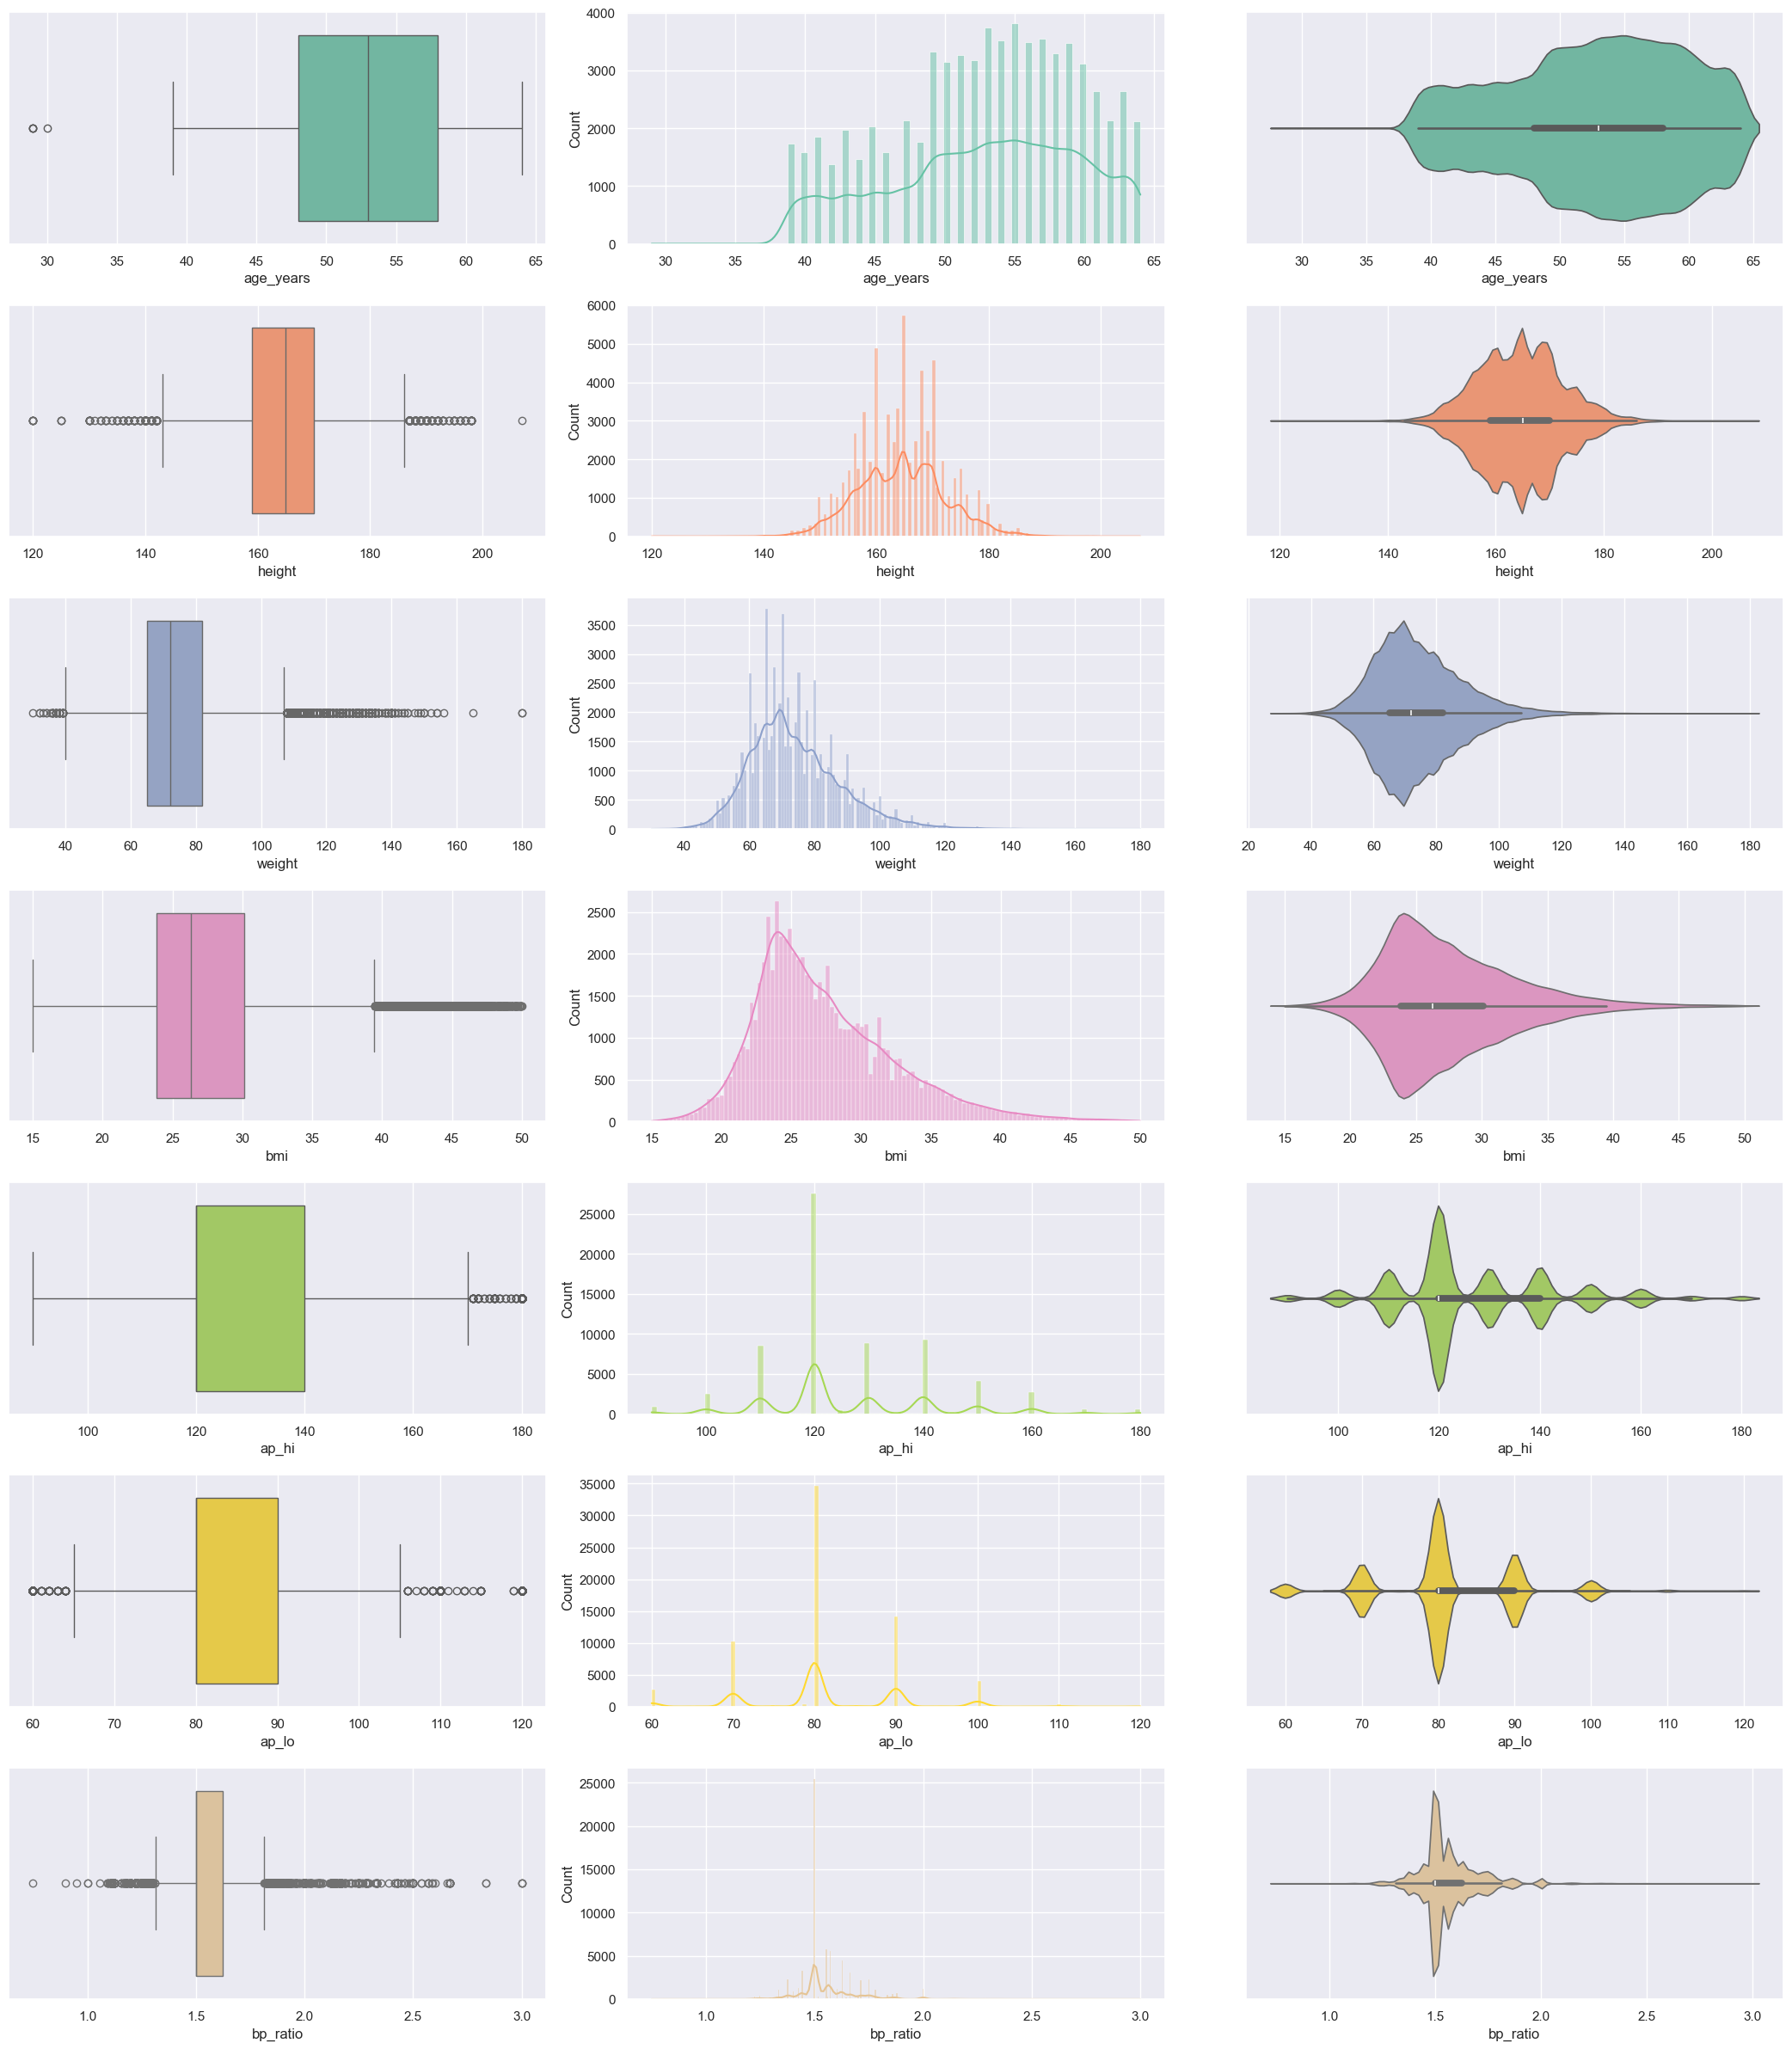

In [11]:
# Extract the numeric variables
numeric_data = pd.DataFrame(sorted_data[["age_years", "height", 'weight', 'bmi', 'ap_hi', 'ap_lo', 'bp_ratio']])

# Draw the distributions of all numeric variables (with differnet coloes, we use set 2.)
f, axes = plt.subplots(7, 3, figsize=(21, 24))
colors = sb.color_palette("Set2", 7)

count = 0
for var in numeric_data:
    color = colors[count]
    sb.boxplot(data = numeric_data[var], orient = "h", ax = axes[count,0], color = color)
    sb.histplot(data = numeric_data[var], kde = True, ax = axes[count,1], color = color)
    sb.violinplot(data = numeric_data[var], orient = "h", ax = axes[count,2], color = color)
    count += 1
    if count == 7:
        break

plt.tight_layout()
plt.show()

* Catigorical data

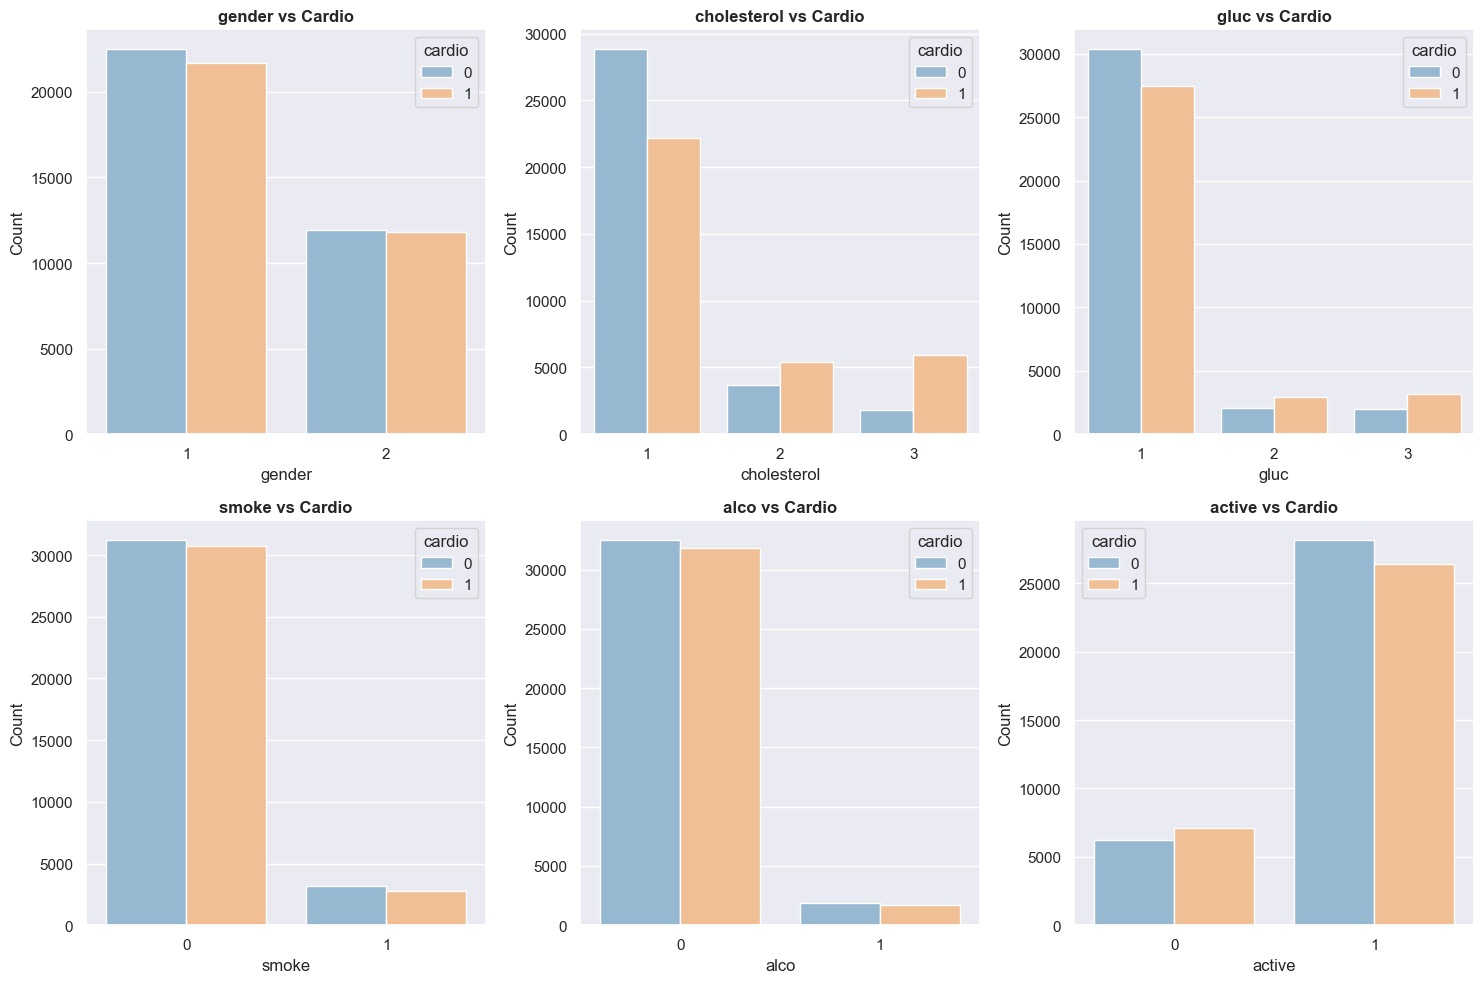

In [12]:
# Extract Categorical Variables
categorical_cols = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    sb.countplot(x=col, hue='cardio', data=data, ax=axes[i], palette = ['#8DB9DB', '#FFBE86'])
    axes[i].set_title(f'{col} vs Cardio', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

1.2 Bi-Variate Visualization  

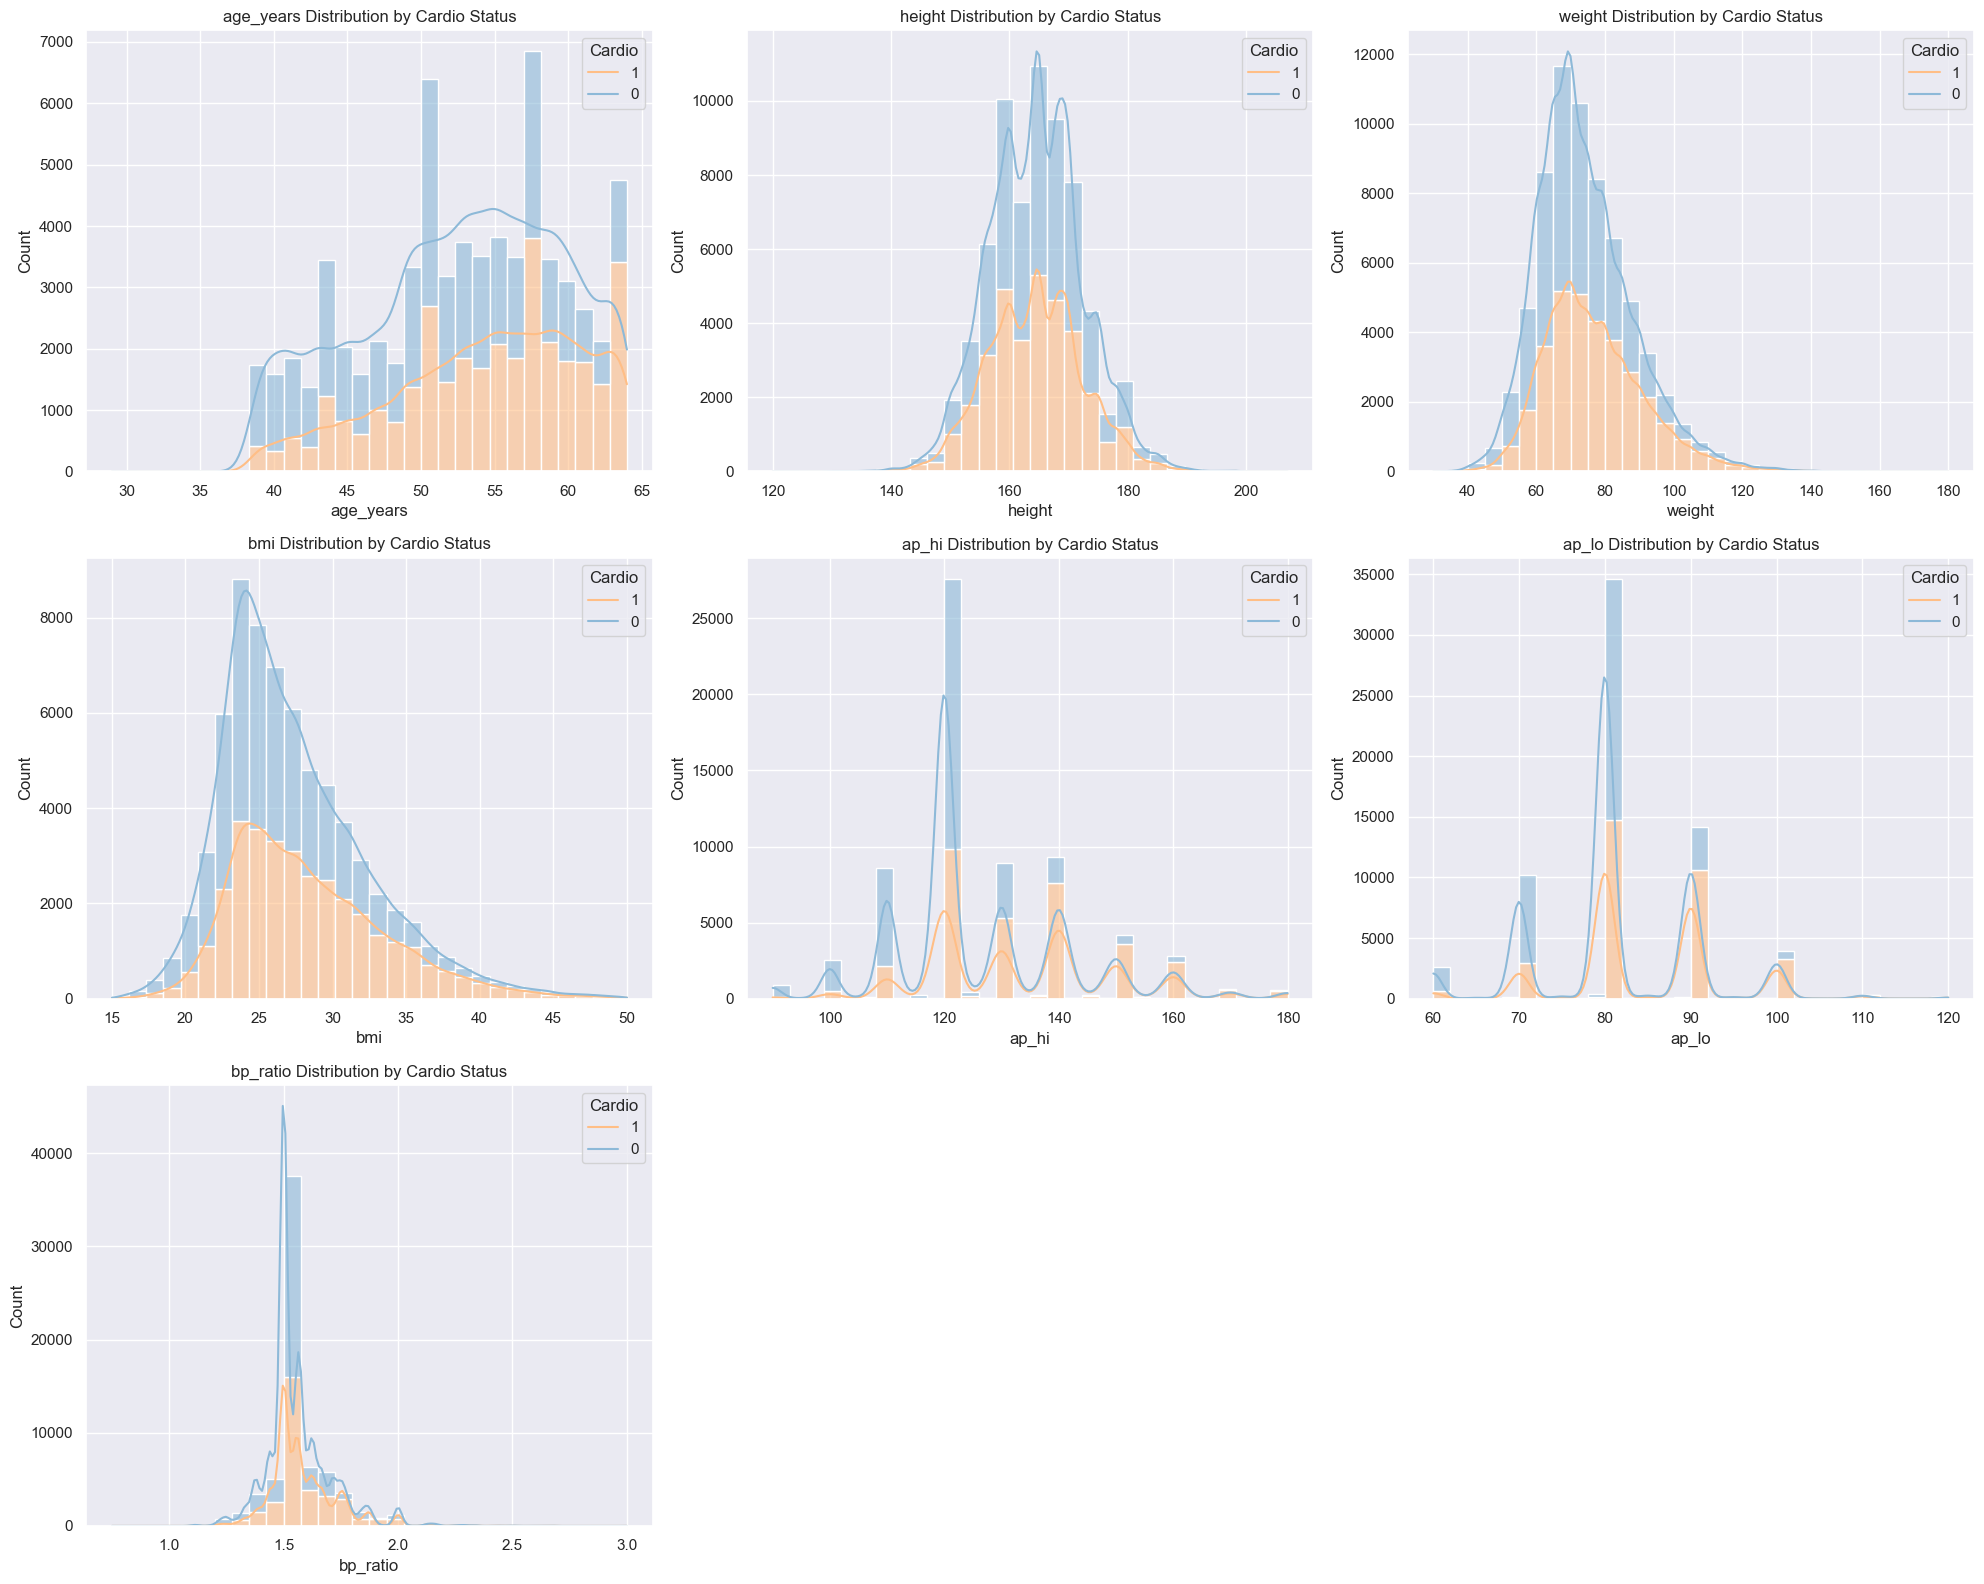

In [13]:
pair_cols = ["age_years", "height", "weight", "bmi", "ap_hi", "ap_lo", "bp_ratio"]
numeric_data = data[pair_cols]
palette = {0: '#8DB9D8', 1: '#FFBE86'}

plt.figure(figsize=(20, 16))

for i, col in enumerate(pair_cols):
    plt.subplot(3, 3, i+1)  
    sb.histplot(data=data, x=col, hue='cardio', multiple='stack', bins=30, kde=True, 
                palette=palette, alpha=0.6)
    plt.title(f'{col} Distribution by Cardio Status')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.legend(title='Cardio', labels=['1', '0'])

plt.tight_layout()
plt.show()

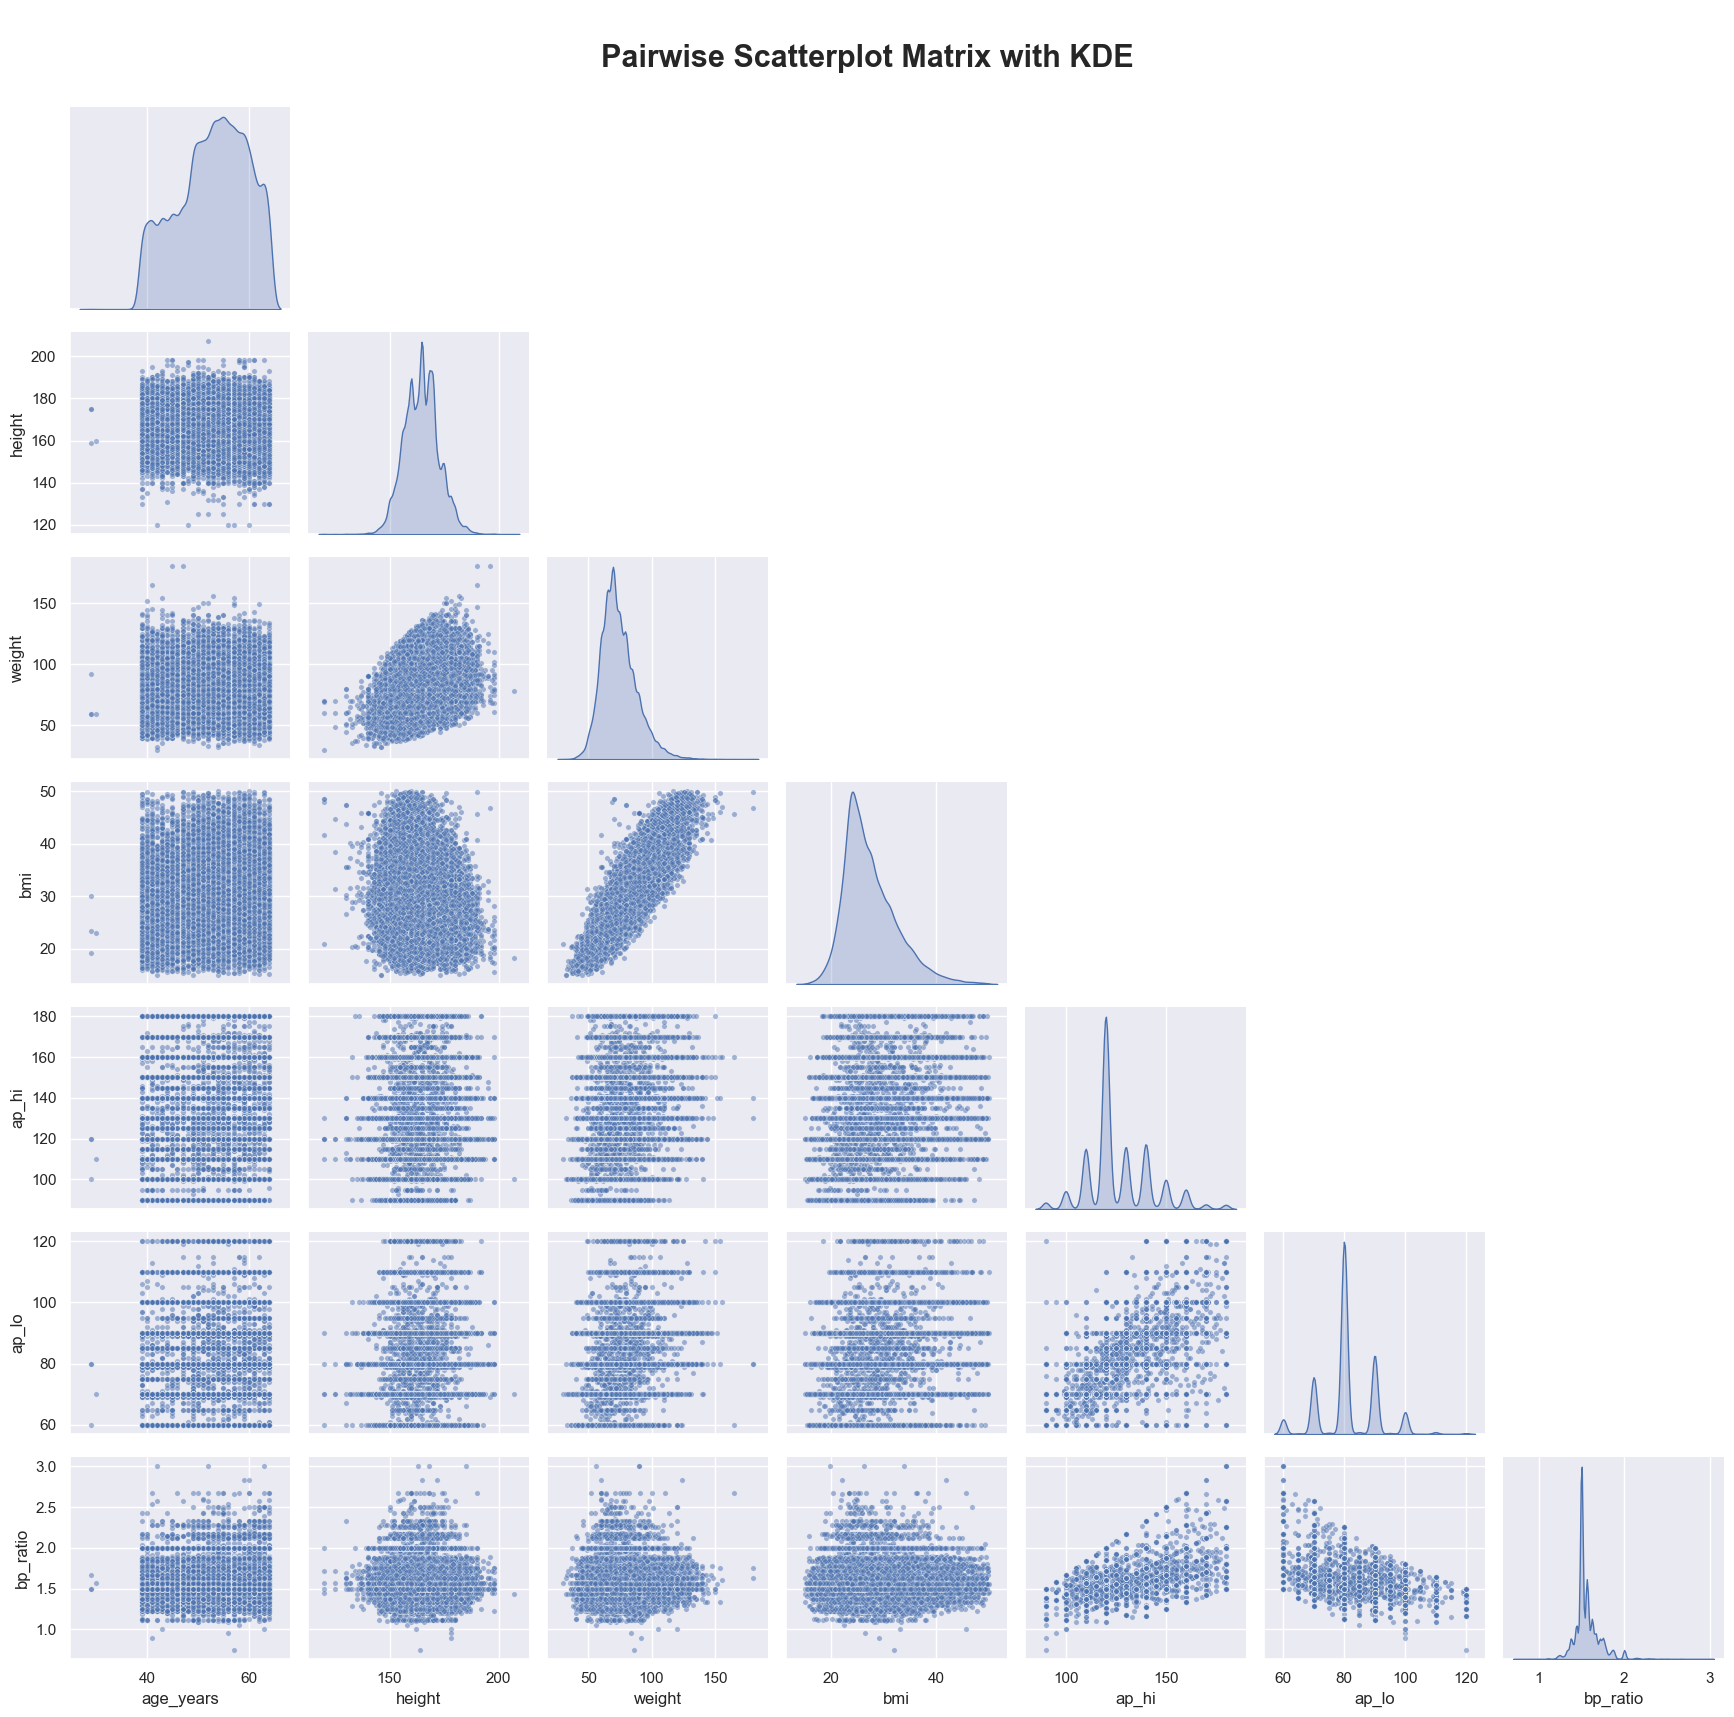

In [14]:
numeric_data = data[["age_years", "height", "weight", "bmi", "ap_hi", "ap_lo", "bp_ratio"]]

sb.pairplot(numeric_data, kind='scatter', diag_kind='kde', corner=True, plot_kws={'alpha': 0.5, 's': 15})
plt.suptitle('\nPairwise Scatterplot Matrix with KDE\n', fontsize=22, fontweight='bold')
plt.tight_layout()
plt.show()

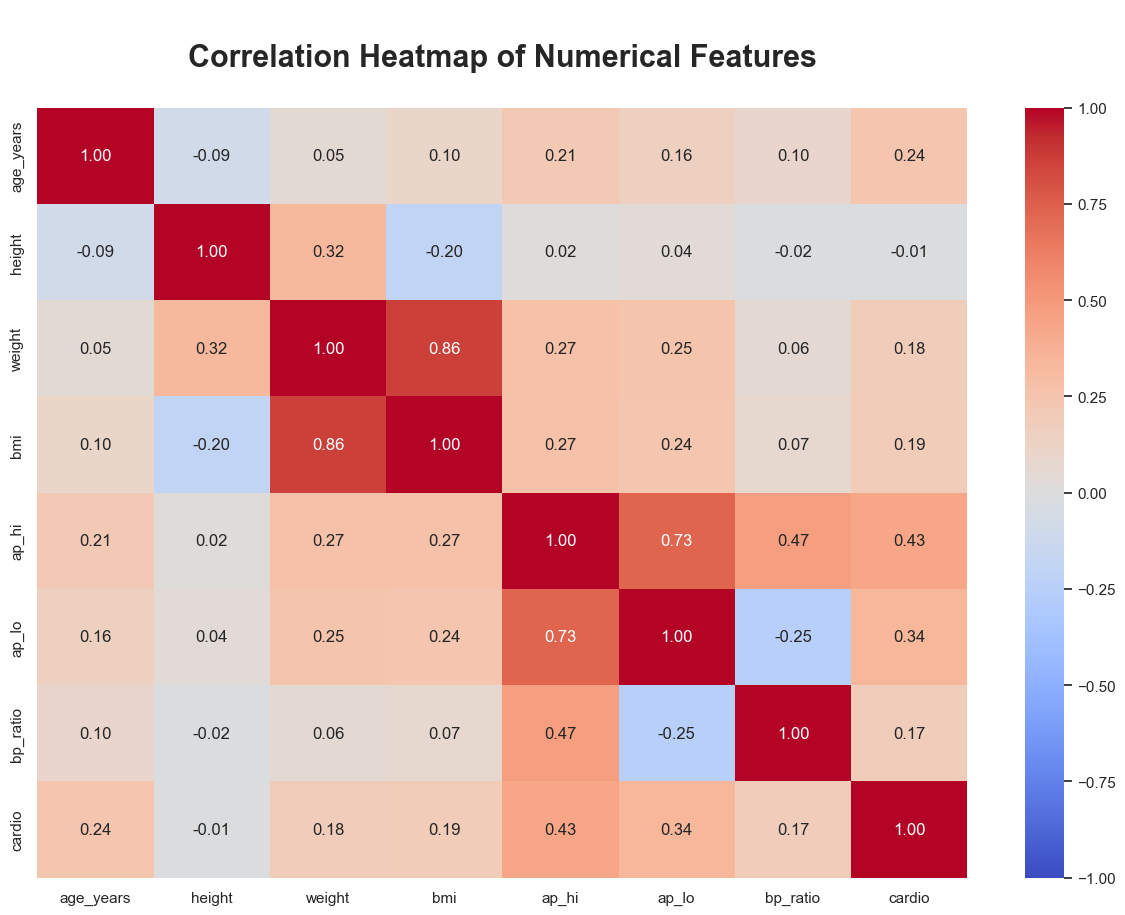

In [15]:
# Select numerical columns
numerical_cols = ['age_years', 'height', 'weight', 'bmi', 'ap_hi', 'ap_lo', 'bp_ratio', 'cardio']
correlation_matrix = data[numerical_cols].corr()
# Plot heatmap
plt.figure(figsize=(15,10))
sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmax = 1, vmin = -1)
plt.title('\nCorrelation Heatmap of Numerical Features\n', fontsize = 22, fontweight = 'bold')
plt.show()
#largest indicator of cardio disease is ap_hi, high blood pressure of 0.47

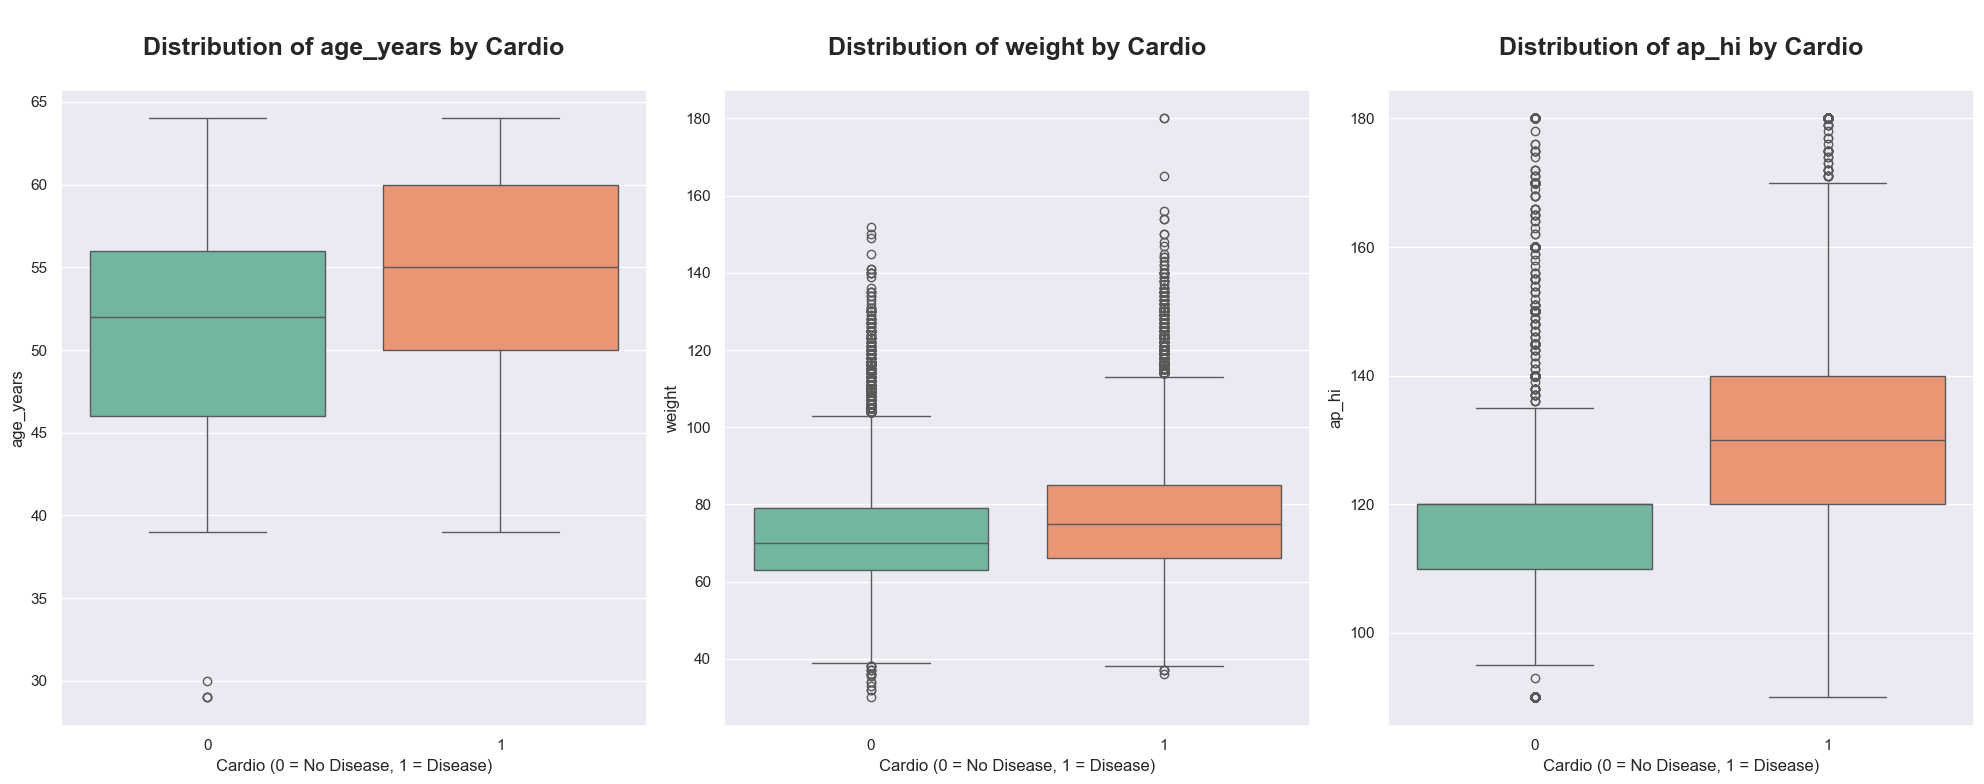

In [ ]:
# Chosse the comparing variables
variables = ["age_years", "weight", "ap_hi"]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 8))

# According to the category of "cardio", draw the distributions of "age_years"; "weight"; "ap_hi"
for i, var in enumerate(variables):
    sb.boxplot(x="cardio", y=var, data=sorted_data, ax=axes[i], palette="Set2", hue = "cardio", legend = False)
    axes[i].set_title(f"\nDistribution of {var} by Cardio\n", fontsize = 18, fontweight = 'bold')
    axes[i].set_xlabel("Cardio (0 = No Disease, 1 = Disease)")
    axes[i].set_ylabel(var)

plt.tight_layout()
plt.show()

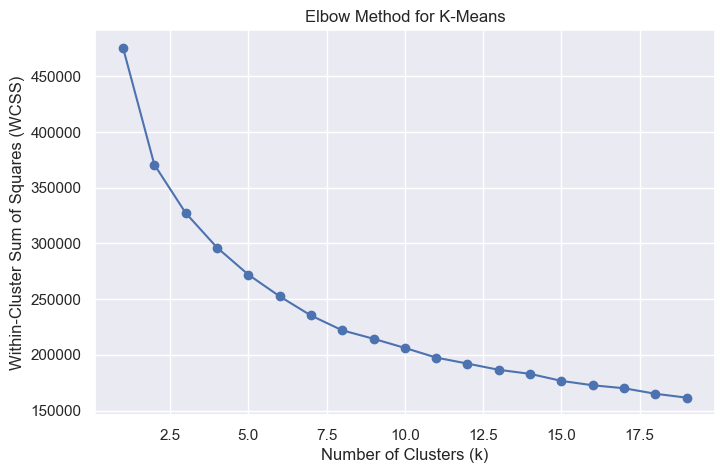

In [17]:
from sklearn.cluster import KMeans
num_cols = ["age_years", "height", "weight", "bmi", "ap_hi", "ap_lo", "bp_ratio"]
X = data[num_cols].copy()

# standardlize the scale of each variable. 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# create the elbow graph to get optimal K.
inertia = []
k_range = range(1, 20)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# plot
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for K-Means')
plt.grid(True)
plt.show()

In [18]:
# From the plot above, can know the optimal K = 5
k = 6
model = NearestNeighbors(n_neighbors=k)
model.fit(X_scaled)
distances, _ = model.kneighbors(X_scaled)

distances = distances[:, k-1]
threshold = np.percentile(distances, 97)  # set the fraction 97% and 3%

# Finally remove the anomaly value. 
mask = distances < threshold
clean_data = data[mask].reset_index(drop=True)

clean_data.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bp_ratio,bmi
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50,1.375000,21.967120
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55,1.555556,34.927679
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,51,1.857143,23.507805
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48,1.500000,28.710479
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,47,1.666667,23.011177


* 2.1 RandomForest.

Accuracy: 0.7343481339132194

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.79      0.76     10295
           1       0.75      0.67      0.71      9479

    accuracy                           0.73     19774
   macro avg       0.74      0.73      0.73     19774
weighted avg       0.74      0.73      0.73     19774


Feature Importance:
         Feature  Importance
5         ap_hi    0.383462
6         ap_lo    0.193452
0     age_years    0.121569
8   cholesterol    0.087024
7      bp_ratio    0.079520
4           bmi    0.051853
3        weight    0.036645
2        height    0.020462
9          gluc    0.009303
12       active    0.007560
1        gender    0.003971
10        smoke    0.003489
11         alco    0.001691


C:\Users\18904\AppData\Local\Temp\ipykernel_18320\2494659483.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x='Importance', y='Feature', data=feature_importance, palette=colors)


<Figure size 1200x800 with 0 Axes>

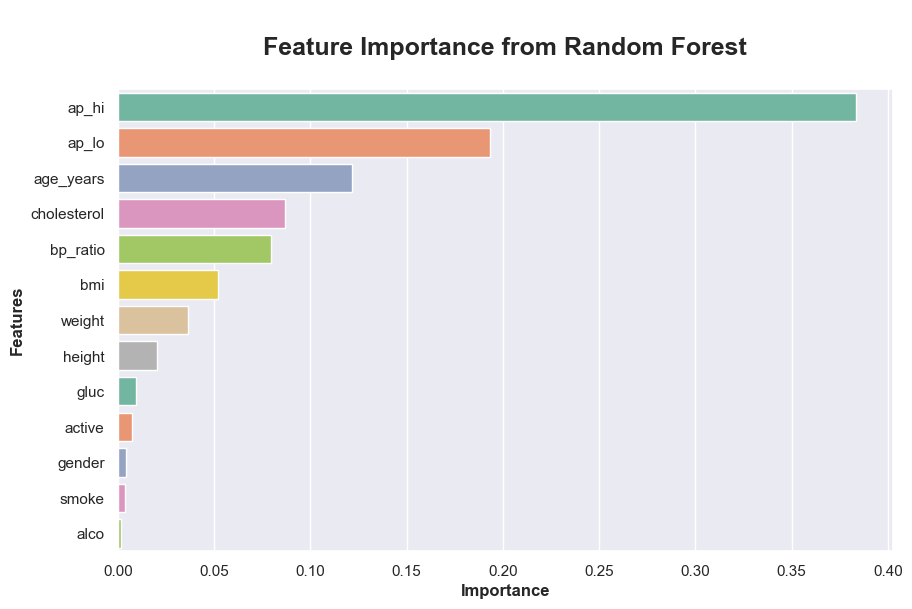

In [26]:
# This shell only for parameter adjusting and trying. 

# Features (including derived features)
features = ['age_years', 'gender', 'height', 'weight', 'bmi', 'ap_hi', 'ap_lo', 'bp_ratio', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']

X = clean_data[features]
y = clean_data['cardio']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

for i in range(9,10):
    # Initialize and train the Random Forest model
    rf_model = RandomForestClassifier(n_estimators=450, random_state=42,max_depth=11,
        max_features='sqrt',
        min_samples_split=14,
        min_samples_leaf=16)
    rf_model.fit(X_train, y_train)

    # Make predictions
    y_pred = rf_model.predict(X_test)

# Evaluate the model
    print("Accuracy:", accuracy_score(y_test, y_pred))

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance:\n", feature_importance)

# Plot feature importance
plt.figure(figsize=(12,8))
colors = sb.color_palette("Set2", len(feature_importance))

plt.figure(figsize=(10, 6))
sb.barplot(x='Importance', y='Feature', data=feature_importance, palette=colors)
plt.title('\nFeature Importance from Random Forest\n', fontsize = 18, fontweight = 'bold')
plt.xlabel('Importance', fontweight = 'bold')
plt.ylabel('Features', fontweight = 'bold')
plt.show()

* 2.2 Gradient Boosting Model

Accuracy: 0.7382421361383635

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.79      0.76     10295
           1       0.75      0.69      0.72      9479

    accuracy                           0.74     19774
   macro avg       0.74      0.74      0.74     19774
weighted avg       0.74      0.74      0.74     19774


Feature Importance:
         Feature  Importance
5         ap_hi    0.682010
0     age_years    0.129116
8   cholesterol    0.078340
4           bmi    0.033362
3        weight    0.021208
2        height    0.011205
12       active    0.009616
6         ap_lo    0.009525
7      bp_ratio    0.009087
9          gluc    0.008070
10        smoke    0.004143
11         alco    0.002194
1        gender    0.002126


C:\Users\18904\AppData\Local\Temp\ipykernel_18320\3989648422.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x='Importance', y='Feature', data=feature_importance, palette=colors)


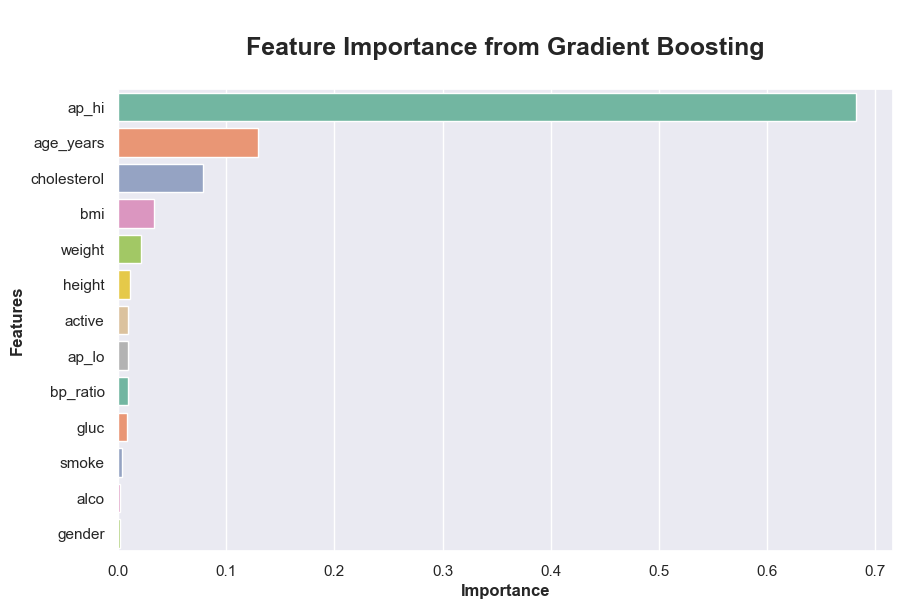

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report

# Features (including derived features)
features = ['age_years', 'gender', 'height', 'weight', 'bmi', 'ap_hi', 'ap_lo', 'bp_ratio', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
X = clean_data[features]
y = clean_data['cardio']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=200, random_state=42,  
    learning_rate=0.05,     
    max_depth=4,          
    subsample=0.74     )    
gb_model.fit(X_train, y_train)

# Make predictions
y_pred = gb_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': gb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance:\n", feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
colors = sb.color_palette("Set2", len(feature_importance))

sb.barplot(x='Importance', y='Feature', data=feature_importance, palette=colors)
plt.title('\nFeature Importance from Gradient Boosting\n', fontsize=18, fontweight='bold')
plt.xlabel('Importance', fontweight='bold')
plt.ylabel('Features', fontweight='bold')
plt.show()

Accuracy: 0.7221098412056235

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.83      0.76     10295
           1       0.77      0.60      0.68      9479

    accuracy                           0.72     19774
   macro avg       0.73      0.72      0.72     19774
weighted avg       0.73      0.72      0.72     19774


Feature Importance (from Linear SVM):
         Feature  Importance
7      bp_ratio    2.664327
8   cholesterol    0.546115
12       active    0.287648
11         alco    0.247782
10        smoke    0.140770
9          gluc    0.079983
6         ap_lo    0.064406
0     age_years    0.052714
1        gender    0.037051
5         ap_hi    0.030840
4           bmi    0.014705
3        weight    0.006694
2        height    0.002690


C:\Users\18904\AppData\Local\Temp\ipykernel_18320\3498623672.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x='Importance', y='Feature', data=feature_importance, palette=colors)


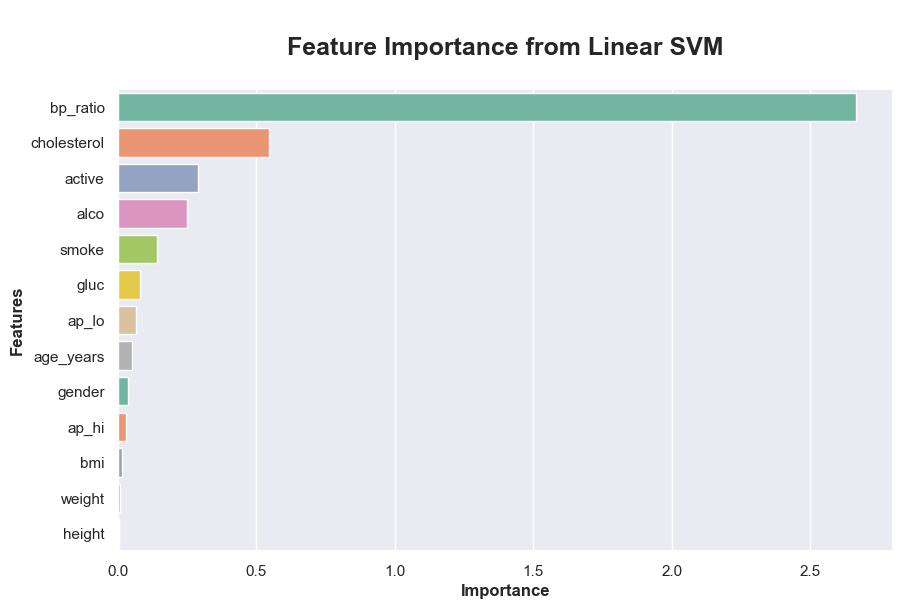

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Features (including derived features)
features = ['age_years', 'gender', 'height', 'weight', 'bmi', 'ap_hi', 'ap_lo', 'bp_ratio', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
X = clean_data[features]
y = clean_data['cardio']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the SVM model
svm_model = SVC(kernel='rbf', random_state=42)  # Using RBF kernel as default
svm_model.fit(X_train, y_train)

# Make predictions
y_pred = svm_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

svm_linear = SVC(kernel='linear', random_state=42)
svm_linear.fit(X_train, y_train)

feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': abs(svm_linear.coef_[0])  # Absolute values of coefficients
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance (from Linear SVM):\n", feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
colors = sb.color_palette("Set2", len(feature_importance))

sb.barplot(x='Importance', y='Feature', data=feature_importance, palette=colors)
plt.title('\nFeature Importance from Linear SVM\n', fontsize=18, fontweight='bold')
plt.xlabel('Importance', fontweight='bold')
plt.ylabel('Features', fontweight='bold')
plt.show()

* 3.4 Stacking & Cross Validation

In [22]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score

features = ['age_years', 'gender', 'height', 'weight', 'bmi', 'ap_hi', 'ap_lo', 
           'bp_ratio', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
X = clean_data[features]
y = clean_data['cardio']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

base_models = [
    ('rf', RandomForestClassifier(n_estimators=50, random_state=42)),  
    ('gb', GradientBoostingClassifier(n_estimators=50, random_state=42)) 
]

stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(),
    cv=3, 
    n_jobs=-1
)

stacking_model.fit(X_train, y_train)
y_pred = stacking_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
cv_scores = cross_val_score(stacking_model, X, y, cv=3, n_jobs=-1)
y_pred = stacking_model.predict(X_test)

print("Stacking Result: ")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"AVG Accuracy: {np.mean(cv_scores):.4f}")
print(f"standard deviation: {np.std(cv_scores):.4f}")
print(f"Recall Rate: {recall_score(y_test, y_pred):.4f}")

# Save the stacking model instead of rf_model
joblib.dump(stacking_model, 'cardio_train_model.pkl')
print("Stacking model saved as 'cardio_train_model.pkl'")

Stacking Result: 
Accuracy: 0.7351
AVG Accuracy: 0.7318
standard deviation: 0.0003
Recall Rate: 0.6910
Stacking model saved as 'cardio_train_model.pkl'


_3.5_ **Based on feedback in class, we adjust something here.**  
* We find importance of features and find deeper features that indicate more accurate.  
* Here we apply _xgboost_ model, use __part of__ features, and got __MAP__, __BMI__ new indicator and so on.  
*Finally got 80+% accuracy.  
* Reference: Kaggle.  

In [23]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, classification_report
from imblearn.combine import SMOTETomek
import xgboost as xgb

df = pd.read_csv('cardio_train.csv', sep=';')
df['age'] = df['age'] / 365.25

df.drop(columns=['id'], inplace=True)

# Feature Engineering got reference from Kaggle. 
df['bmi'] = df['weight'] / (df['height'] / 100) ** 2
df['pulse_pressure'] = df['ap_hi'] - df['ap_lo']
df['map'] = df['ap_lo'] + (df['ap_hi'] - df['ap_lo']) / 3
df['age_bmi_interaction'] = df['age'] * df['bmi']
df['pulse_map_interaction'] = df['pulse_pressure'] * df['map']
df.drop(columns=['height', 'weight', 'ap_hi', 'ap_lo'], inplace=True)
df.fillna(df.median(), inplace=True)

X = df.drop(columns=['cardio'])
y = df['cardio']
feature_names = X.columns.tolist()

sm = SMOTETomek(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_df = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_df = pd.DataFrame(X_test_scaled, columns=feature_names)

xgb_model = xgb.XGBClassifier(
    max_depth=9,
    learning_rate=0.01,
    n_estimators=1200,
    subsample=0.85,
    colsample_bytree=0.85,
    gamma=0.5,
    reg_alpha=1,
    reg_lambda=1,
    scale_pos_weight=1,
    early_stopping_rounds=100,
    tree_method='hist',
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled, y_test)], verbose=0)

y_pred = xgb_model.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.8004831350093943
              precision    recall  f1-score   support

           0       0.78      0.84      0.81      5563
           1       0.82      0.77      0.79      5614

    accuracy                           0.80     11177
   macro avg       0.80      0.80      0.80     11177
weighted avg       0.80      0.80      0.80     11177



## Interface Visualizaiton

In [24]:
streamlit_code = """import streamlit as st
import joblib
import pandas as pd
import plotly.graph_objects as go

# Load the pre-trained stacking model
try:
    model = joblib.load('cardio_train_model.pkl')
except FileNotFoundError:
    st.error("Error: 'cardio_train_model.pkl' not found. Please ensure the stacking model is trained and saved.")
    st.stop()

# Define the feature names (must match training features)
feature_names = ['age_years', 'gender', 'height', 'weight', 'bmi', 'ap_hi', 'ap_lo', 
                 'bp_ratio', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']

# Create the Streamlit web app
st.title("Cardiovascular Disease Risk Predictor")
st.markdown("Enter your details below to predict your risk of cardiovascular disease using a stacked model.")

# Input form
with st.form("cvd_form"):
    st.subheader("Personal Information")
    age_years = st.slider("Age (years)", min_value=20, max_value=100, value=50)
    gender = st.selectbox("Gender", options=["Female (1)", "Male (2)"])
    height = st.slider("Height (cm)", min_value=100, max_value=250, value=170)
    weight = st.slider("Weight (kg)", min_value=30, max_value=200, value=70)

    st.subheader("Health Metrics")
    ap_hi = st.slider("Systolic Blood Pressure (mmHg)", min_value=50, max_value=250, value=120)
    ap_lo = st.slider("Diastolic Blood Pressure (mmHg)", min_value=30, max_value=150, value=80)
    cholesterol = st.selectbox("Cholesterol Level", options=["Normal (1)", "Above Normal (2)", "Well Above Normal (3)"])
    gluc = st.selectbox("Glucose Level", options=["Normal (1)", "Above Normal (2)", "Well Above Normal (3)"])

    st.subheader("Lifestyle Factors")
    smoke = st.selectbox("Do you smoke?", options=["No (0)", "Yes (1)"])
    alco = st.selectbox("Do you consume alcohol?", options=["No (0)", "Yes (1)"])
    active = st.selectbox("Are you physically active?", options=["No (0)", "Yes (1)"])

    submitted = st.form_submit_button("Predict Risk")

# Process the prediction
if submitted:
    # Extract values
    gender_val = int(gender.split()[1].strip("()"))
    cholesterol_val = int(cholesterol.split()[1].strip("()"))
    gluc_val = int(gluc.split()[1].strip("()"))
    smoke_val = int(smoke.split()[1].strip("()"))
    alco_val = int(alco.split()[1].strip("()"))
    active_val = int(active.split()[1].strip("()"))

    # Calculate BMI and BP ratio
    bmi = weight / ((height / 100) ** 2)
    bp_ratio = ap_hi / ap_lo if ap_lo != 0 else 0

    # Create user data DataFrame
    user_data = pd.DataFrame({
    'age_years': [age_years],
    'gender': [gender_val],
    'height': [height],
    'weight': [weight],
    'bmi': [bmi],
    'ap_hi': [ap_hi],
    'ap_lo': [ap_lo],
    'bp_ratio': [bp_ratio],
    'cholesterol': [cholesterol_val],
    'gluc': [gluc_val],
    'smoke': [smoke_val * 3.0],
    'alco': [alco_val * 3.0],
    'active': [active_val],
    #'smoke_penalty': [smoke_val * 0.1], 
    #We realise that the dataset is not accurate as it is biased, they sow that non smokers and non drinkers has higher CVD, which is contradictory to the known medical knowledge
    #Hence, we added a penalty feature for this
    #'alco_penalty': [alco_val * 0.1]
})

    # Predict probability using the stacking model
    probability = model.predict_proba(user_data)[0][1]
    percentage = probability * 100

    # Display result
    st.subheader("Prediction Result")
    st.write(f"**Your Risk of Cardiovascular Disease: {percentage:.2f}%**")
    if percentage > 50:
        st.error("High Risk! Consider consulting a healthcare professional.")
    else:
        st.success("Low Risk. Maintain a healthy lifestyle.")

    # Risk gauge
    fig = go.Figure(go.Indicator(
        mode="gauge+number",
        value=percentage,
        title={'text': "CVD Risk Percentage"},
        gauge={
            'axis': {'range': [0, 100]},
            'bar': {'color': "darkblue"},
            'steps': [
                {'range': [0, 50], 'color': "green"},
                {'range': [50, 75], 'color': "orange"},
                {'range': [75, 100], 'color': "red"}
            ],
            'threshold': {
                'line': {'color': "black", 'width': 4},
                'thickness': 0.75,
                'value': 50
            }
        }
    ))
    st.plotly_chart(fig)

    # Health tips
    st.subheader("Health Tips")
    if cholesterol_val == 3:
        st.info("High cholesterol detected. Consider a low-fat diet and consult a doctor.")
    if ap_hi > 140 or ap_lo > 90:
        st.info("High blood pressure detected. Exercise and diet changes may help.")
    if active_val == 0:
        st.info("Consider adding 150+ minutes of weekly exercise to reduce risk.")
        """

# Save the Streamlit code to a file
with open('cvd_app.py', 'w') as f:
    f.write(streamlit_code)
print("Streamlit app code saved as 'cvd_app.py'")

Streamlit app code saved as 'cvd_app.py'


In [25]:
# Run the Streamlit app from Jupyter Notebook
import subprocess
import time

# Start the Streamlit server
process = subprocess.Popen(['streamlit', 'run', 'cvd_app.py'], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
# Wait a few seconds for the server to start
time.sleep(5)
# Print the URL to access the app
print("Streamlit app is running. Open your browser and go to: http://localhost:8501")
# To stop the app, you can interrupt the kernel (or stop the cell manually)

Streamlit app is running. Open your browser and go to: http://localhost:8501


## Above is all of our code work.  
- IE0005 Mini Project - __EL20 Group 3__  
> Visual: Zhanghao, Zelin.  
> Model: Wannee, Mingzhi.  
* 2025.04.15  

——————————————————END——————————————————